In [1]:
# setup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we use regularized linear models
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# for train/test or CV
from sklearn.model_selection import train_test_split as tts

# for scaling
from sklearn.preprocessing import StandardScaler

# we need some stats methods
from scipy.stats import norm, uniform, beta, gamma, triang, kstest, anderson, shapiro

In [2]:
# we need some real data for regression
data = pd.read_csv('https://github.com/dvasiliu/AML/blob/main/Data%20Sets/concrete.csv?raw=true')

In [3]:
data

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [5]:
x = data.drop(columns='strength').values
y = data['strength'].values

In [8]:
# we want to generate some probable errors via regression
model = Ridge(alpha=0.01)
model.fit(x,y)
errors = y - model.predict(x)

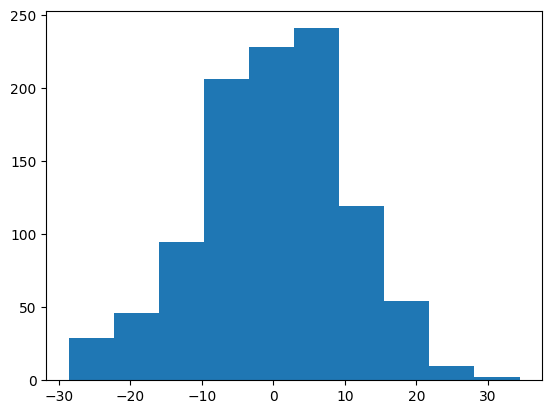

In [10]:
plt.hist(errors)
plt.show()

In [9]:
# useful class for the visualization of frequencies
class distribution_plot:
  def __init__(self,dist,bins=11,hist_color='lightblue',pdf_color='red',fill_region=False,fill_color='lightgreen',fill_bounds=[-1,1],edge_color='k',lw_pdf=2):
    # here we have the instance attributes
    self.dist = dist
    self.bins = bins
    self.hist_color = hist_color
    self.pdf_color = pdf_color
    self.edgecolor = edge_color
    self.lw_pdf = lw_pdf
    self.fill_region = fill_region
    self.fill_color = fill_color
    self.fill_bounds = fill_bounds


  def fit(self,data):
    fig, ax = plt.subplots(figsize=(6, 5))
    # Create the histogram
    sns.histplot(data,
                bins=self.bins,
                kde=False,
                color=self.hist_color,
                alpha=0.5,
                edgecolor=self.edgecolor,
                ax=ax)

    # Calculate the parameters for the normal distribution fit
    params = self.dist.fit(data)

    # Create the x values for the normal distribution curve
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Calculate the y values for the normal distribution curve
    p = self.dist.pdf(x, *params)

    # Plot the normal distribution curve, scaling it to the histogram
    # We need to scale it because histplot uses counts, while norm.pdf is a density
    scale_factor = len(data) * (xmax - xmin) / self.bins # Approximate bin width
    ax.plot(x, p * scale_factor, 'r', linewidth=self.lw_pdf)

    ax.set_xlabel('Random Variable', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_title('Data Distribution', fontsize=16)
    if self.fill_region:
      l = ax.lines[0]
      xx = l.get_xydata()[:,0]
      yy = l.get_xydata()[:,1]
      ax.fill_between(xx,yy, where=(self.fill_bounds[0]<=xx) & (xx <= self.fill_bounds[1]), color=self.fill_color,alpha=0.5)
      plt.savefig('example_distribution.png',dpi=300)
    plt.show()

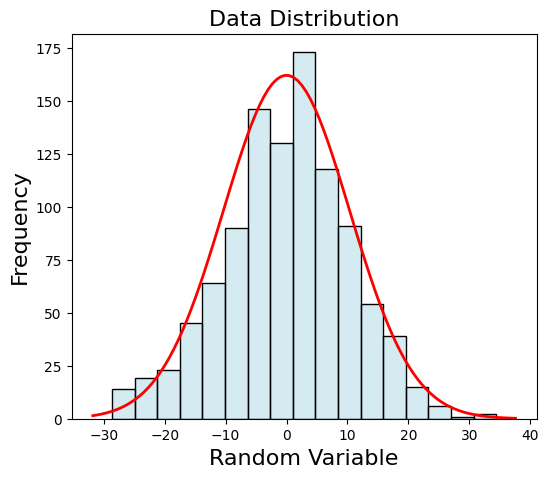

In [13]:
deviatgions

In [15]:
# here we assumed 'val' is only a 1-dim array
def zscore(val):
    return (val-np.mean(val))/np.std(val)

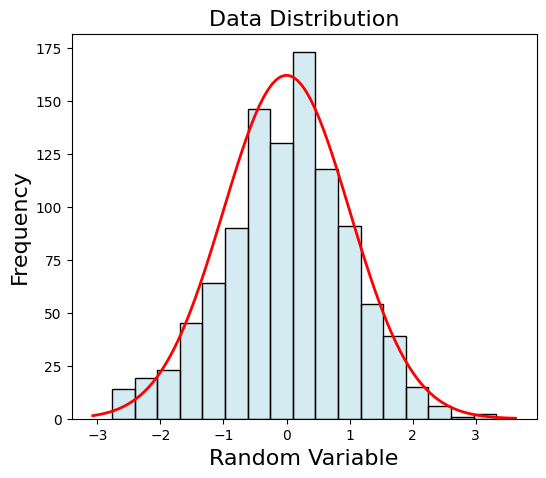

In [16]:
visualize = distribution_plot(norm, bins=17)
visualize.fit(zscore(errors))

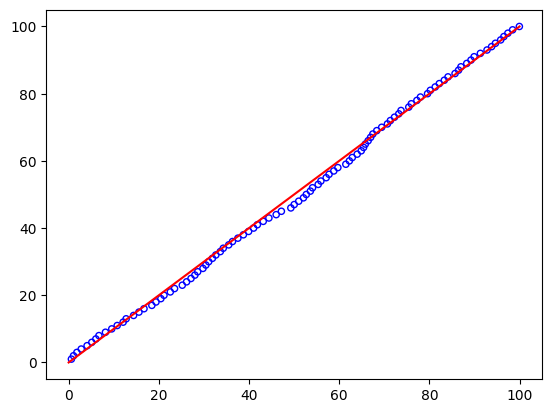

In [24]:
# now we want to create Q-Q plot
percents = np.arange(1,101,1)
# now we compute the empirical percentiles 
em_percentiles = np.percentile(zscore(errors),percents)
em_percents = norm.cdf(em_percentiles)
# here below we show the actual plot
plt.scatter(em_percents*100, percents,s=20,marker='o', facecolor='none',edgecolor='blue')
plt.plot([0,100],[0,100],color='red')
plt.show()

In [25]:
# now we want to apply more detailed normality tests:
# K-S
kstest(zscore(errors),'norm')

KstestResult(statistic=np.float64(0.03381258343368981), pvalue=np.float64(0.18535867595167344), statistic_location=np.float64(-0.010155764581134041), statistic_sign=np.int8(-1))

So, the K-S test is saysing that your errors do not violate the normality assumption since the p-value is quite high such as 18%.

In [26]:
# Anderson-Darling test
anderson(zscore(errors))

AndersonResult(statistic=np.float64(1.2397558976304026), critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(0.0), scale=np.float64(1.0004857906528948))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

The Anderson-Darling test is rejecting the normality assumption due to deviations of the emprical quantiles from the theoretical ones at extremmities.

In [27]:
# Shapiro-Wilk
shapiro(zscore(errors))

ShapiroResult(statistic=np.float64(0.9953233247605099), pvalue=np.float64(0.0029925928784472018))

The Shapiro test is saying that the errors are not perfectly normally distributed; however they approximate the normal distribution quite well. Be mindful that p-values are affected by the sample size.

In [45]:
# how about we separate the ddeviatgionsata into a train and test, and check the normality of errors on the test set?
xtrain, xtest, ytrain, ytest = tts(x,y, test_size=0.1, shuffle=True)

In [46]:
scale = StandardScaler()
xtrain = scale.fit_transform(xtrain)
xtest = scale.transform(xtest)

In [ ]:
Text

In [47]:
model = Ridge(alpha=0.01)
model.fit(xtrain,ytrain)
errors = ytest - model.predict(xtest)

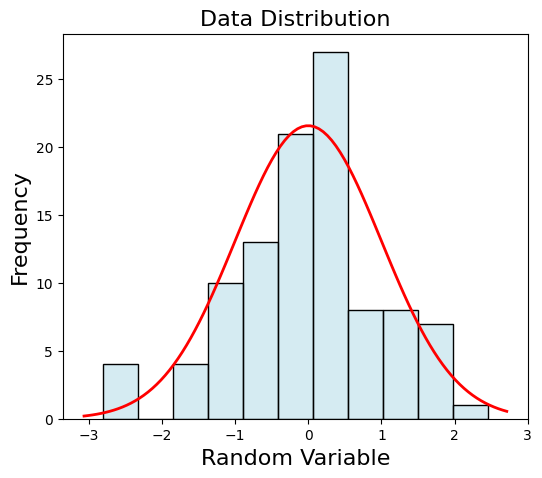

In [49]:
visualize = distribution_plot(norm, bins=11)
visualize.fit(zscore(errors))

In [50]:
kstest(zscore(errors),'norm')

KstestResult(statistic=np.float64(0.08153570410489303), pvalue=np.float64(0.4753968987145457), statistic_location=np.float64(-0.2735497806278593), statistic_sign=np.int8(-1))

In [51]:
anderson(zscore(errors))

AndersonResult(statistic=np.float64(0.7172304723615639), critical_values=array([0.556, 0.633, 0.759, 0.886, 1.054]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-4.311545726699637e-18), scale=np.float64(1.0048900047112757))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

The Anderson test is suggesting that we fail to reject the normality assumption (so data is not violating the normality assumption) since the p-value > 5%

In [52]:
shapiro(zscore(errors))

ShapiroResult(statistic=np.float64(0.9756059722576124), pvalue=np.float64(0.053633896550055044))

So now all three tests are in agreement, and we also demonstrated the samplesize effect on the p-values.

## Demonstrate the Central Limit Theorem

In [2]:
# we create a population that is not normally distributed
# let's simulate a population from a triangular distribution
population = triang.rvs(size=10000,loc=-3, scale=4,c=0.3)

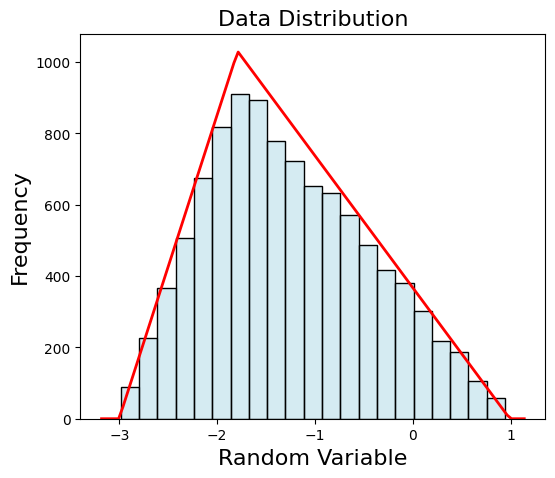

In [77]:
visualize = distribution_plot(triang, bins=21)
visualize.fit(population)

In [3]:
# let's create many sample means
samples = [np.random.choice(population,size=32,replace=False) for _ in range(200)]

In [6]:
means = np.mean(samples, axis=1)

In [7]:
means

array([-1.32887139, -1.40562854, -1.12276547, -1.4125334 , -1.50880054,
       -1.2820786 , -1.52610092, -1.27570293, -1.34059055, -1.37318464,
       -1.42136212, -1.26677944, -1.4658448 , -1.16874966, -1.22072739,
       -1.17058973, -1.20514988, -1.44210231, -1.35547773, -1.15791436,
       -1.42689365, -1.02309746, -1.12093013, -1.17286057, -1.20182962,
       -1.52603828, -1.13920019, -0.80739511, -1.20074245, -1.01469632,
       -1.41080504, -1.14964644, -1.37455582, -1.05326692, -1.38619963,
       -1.39699011, -1.32406773, -1.2169009 , -1.43772324, -1.21460106,
       -1.3677862 , -1.49257746, -1.33408391, -1.74787505, -1.27711668,
       -1.42371843, -1.0436169 , -1.17245786, -1.313908  , -1.10882825,
       -1.28118027, -1.18548177, -1.35293703, -1.18002118, -1.00381328,
       -1.42560099, -1.2287966 , -1.5447016 , -1.21246615, -1.40527537,
       -1.46287676, -1.2264705 , -1.36314391, -1.49313023, -1.52833439,
       -1.19161793, -1.62072913, -1.32686478, -1.39035372, -1.16

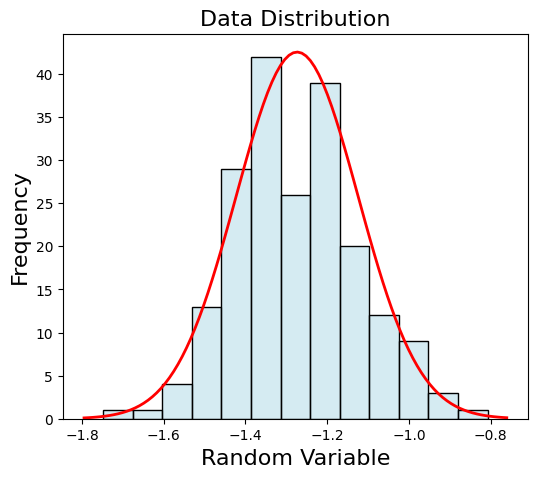

In [12]:
visualize = distribution_plot(norm, bins=13)
visualize.fit(means)

In [15]:
def zscore(val):
    return (val-np.mean(val))/np.std(val)

In [16]:
kstest(zscore(means),'norm')

KstestResult(statistic=np.float64(0.05838772206813431), pvalue=np.float64(0.484905791845187), statistic_location=np.float64(-0.24917611298567982), statistic_sign=np.int8(1))

In [17]:
anderson(zscore(means))

AndersonResult(statistic=np.float64(0.4975159367643869), critical_values=array([0.565, 0.644, 0.772, 0.901, 1.071]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(1.2256862191861727e-15), scale=np.float64(1.002509414234171))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [18]:
shapiro(zscore(means))

ShapiroResult(statistic=np.float64(0.9938044060312057), pvalue=np.float64(0.5718690725847599))

In [21]:
# an example with a beta distribution
population = beta.rvs(size=10000,loc=1, scale=3,a=2.8,b=2.2)

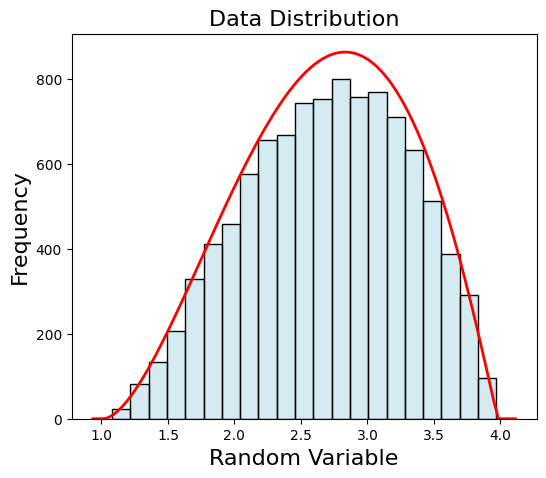

In [22]:
visualize = distribution_plot(beta, bins=21)
visualize.fit(population)

In [25]:
samples = [np.random.choice(population,size=30,replace=True) for _ in range(180)]

In [27]:
means = np.mean(samples, axis=1)

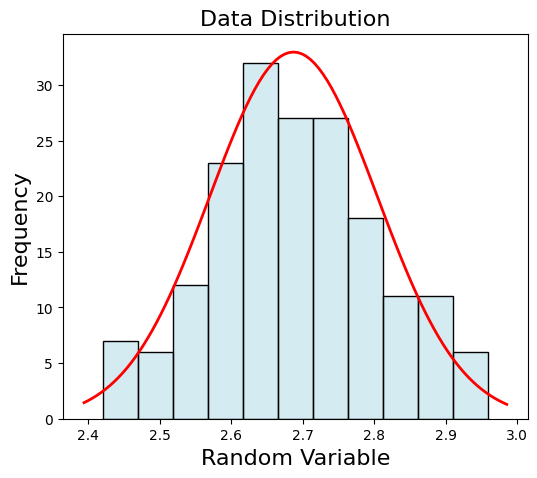

In [30]:
visualize = distribution_plot(norm, bins=11)
visualize.fit(means)

In [31]:
# let's do a q-q plot
percentages = np.arange(1,101,1)

In [35]:
percentages

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [39]:
emp_percentiles = np.percentile(zscore(means),percentages)

In [40]:
emp_percentiles

array([-2.12636515e+00, -2.09576772e+00, -2.01017181e+00, -1.84739091e+00,
       -1.62172179e+00, -1.45575918e+00, -1.42873376e+00, -1.38276255e+00,
       -1.32138810e+00, -1.27523918e+00, -1.23083874e+00, -1.20780811e+00,
       -1.09334846e+00, -1.01438769e+00, -9.57850872e-01, -9.31647091e-01,
       -8.66718281e-01, -8.54859820e-01, -8.27210067e-01, -8.10290747e-01,
       -7.77819800e-01, -7.39947393e-01, -7.12817360e-01, -6.98614658e-01,
       -6.81688056e-01, -6.39102124e-01, -5.98667400e-01, -5.63007209e-01,
       -5.57490836e-01, -5.53462182e-01, -5.45752383e-01, -5.11474047e-01,
       -5.07029131e-01, -4.71606898e-01, -4.50658026e-01, -4.14183835e-01,
       -3.93115151e-01, -3.78409299e-01, -3.35769710e-01, -3.18471872e-01,
       -2.99852232e-01, -2.79674254e-01, -2.34124421e-01, -1.95469732e-01,
       -1.43441054e-01, -1.19852812e-01, -1.08900033e-01, -8.92226300e-02,
       -8.18710222e-02, -7.11494165e-02, -5.62519738e-02, -3.84845680e-02,
       -2.40689123e-02,  

In [41]:
norm.cdf(emp_percentiles)

array([0.01673643, 0.0180514 , 0.0222065 , 0.03234525, 0.05243147,
       0.0727296 , 0.07654039, 0.08336884, 0.093186  , 0.1011123 ,
       0.10919159, 0.11356054, 0.13712042, 0.1551989 , 0.16906898,
       0.17575947, 0.19304819, 0.19631438, 0.204059  , 0.20888655,
       0.21833763, 0.22966596, 0.23797939, 0.24239644, 0.24771811,
       0.26137825, 0.27469735, 0.28671499, 0.28859606, 0.28997348,
       0.29261808, 0.30450958, 0.30606719, 0.3186037 , 0.32611802,
       0.33936974, 0.34711722, 0.35256328, 0.36852227, 0.37506351,
       0.38214494, 0.38986372, 0.40744419, 0.42251262, 0.44297093,
       0.45229987, 0.45664089, 0.46445249, 0.46737464, 0.47163942,
       0.47757054, 0.48465067, 0.49039882, 0.50043775, 0.5076934 ,
       0.54377103, 0.54912579, 0.56334565, 0.57746383, 0.59747959,
       0.61419955, 0.62521947, 0.64661064, 0.65440735, 0.66775208,
       0.67403287, 0.67689324, 0.6816156 , 0.68726389, 0.69527268,
       0.71215956, 0.72030773, 0.72868555, 0.73666195, 0.75138

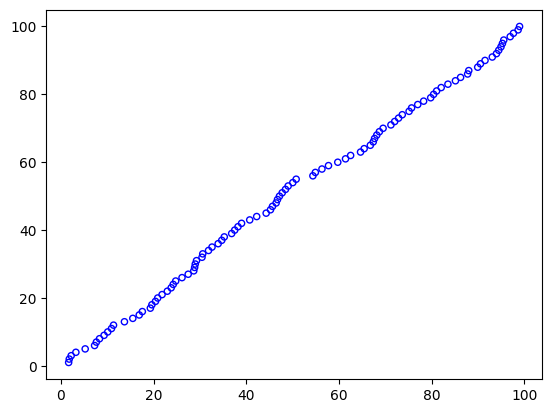

In [42]:
plt.scatter(norm.cdf(emp_percentiles)*100, percentages,s=20, facecolor='none',edgecolor='blue')

In [48]:
# we have to get re-assurance by applying the normality tests
from scipy.stats import kstest, anderson, shapiro

In [49]:
kstest(zscore(means),'norm')

KstestResult(statistic=np.float64(0.04566133255708582), pvalue=np.float64(0.8302992031124884), statistic_location=np.float64(0.010875640877170462), statistic_sign=np.int8(1))

In [50]:
anderson(zscore(means))

AndersonResult(statistic=np.float64(0.30470945830506935), critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-1.8380358963238704e-15), scale=np.float64(1.0027894056973132))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [51]:
shapiro(zscore(means))

ShapiroResult(statistic=np.float64(0.9911891015587873), pvalue=np.float64(0.3385582273599794))